# Bob who is rich is happpy

This experiment was presented at [QNLP 2019](file:///Users/alexis.toumi/WORK/discopy/docs/_build/html/talks/qnlp19.html). The original can by found on [DisCoPy repository](https://github.com/oxford-quantum-group/discopy/tree/main/docs/notebooks).

In [1]:
import pickle
import numpy as np
from sklearn.model_selection import train_test_split
from jax import jit, grad
import jax.numpy as np
from discopy import Ty, Word, Tensor
from discopy.quantum import CX, H, Ket, Rx, Id, sqrt
from discopy import CircuitFunctor, Diagram, Id, Cup, qubit
from discopy.grammar import brute_force
from discopy.rigid import Spider
from discopy.quantum.circuit import Functor
from random import random, uniform, seed
seed(1)

**1) First, we define the atomic pregroup types (typically ‘s’ and ‘n’).**

In [2]:
s, n = Ty('s'), Ty('n')

**2) We assign a number of qubits for each pregroup type.‘s’ is set to 0 qubits, because the qubit for the sentence is only intended to be measured, and hence is to be considered as a scalar.**

In [3]:
ob = {s: 0, n: 1}

**3) Then we construct the finite vocabulary. For each word assign a pregroup type, using atomic pregroup types and invert types.**

In [4]:
Alice = Word('Alice', n)
loves = Word('loves', n.r @ s @ n.l)
Bob =  Word('Bob', n)
who = Word('who', n.r @ n @ s.l @ n)
is_rich = Word('is rich', n.r @ s)
is_happy = Word('is happy', n.r @ s)

vocab = [Alice, loves, Bob, who, is_rich, is_happy]
N = len(vocab)

**4) Every pregroup type will be mapped to a quantum circuit. We explicitely build the quantum circuits.**

Circuit for the GHZ state:


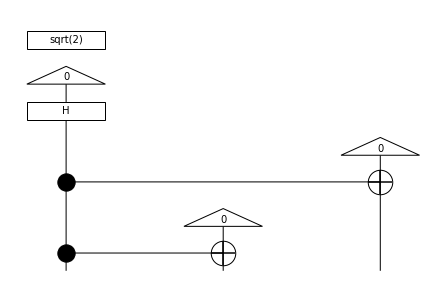

Tensor(dom=Dim(1), cod=Dim(2, 2, 2), array=[1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j])


In [5]:
GHZ = Functor(ob=lambda o: o, ar=lambda a: a)(sqrt(2) @ Spider(0, 3, n))

print("Circuit for the GHZ state:")
GHZ.draw(aspect='auto', draw_type_labels=False)
print(GHZ.eval())

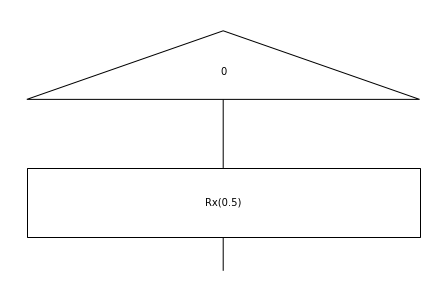

Tensor(dom=Dim(1), cod=Dim(2), array=[6.123234e-17+0.j, 0.000000e+00-1.j])


In [6]:
def intransitive_ansatz(phase):
    return Ket(0) >> Rx(phase)

iv = intransitive_ansatz(0.5)
iv.draw(aspect='auto', draw_type_labels=False)
print(iv.eval())

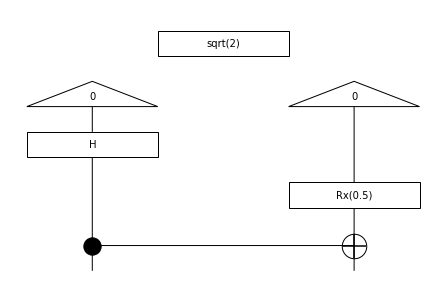

Tensor(dom=Dim(1), cod=Dim(2, 2), array=[6.123234e-17+0.j, 0.000000e+00-1.j, 0.000000e+00-1.j, 6.123234e-17+0.j])


In [7]:
def transitive_ansatz(phase):
    return sqrt(2) @ Ket(0, 0) >> H @ Rx(phase) >> CX

tv = transitive_ansatz(0.5)
tv.draw(aspect='auto', draw_type_labels=False)
print(tv.eval())

**5) We explicit the mapping from each entry in the vocabulary to its corresponding quantum circuit.**

In [8]:
ar = lambda params: {
    Alice: Ket(0),
    loves: transitive_ansatz(params['loves']),
    Bob: Ket(1),
    who: GHZ,
    is_rich: intransitive_ansatz(params['is_rich']),
    is_happy: intransitive_ansatz(params['is_happy'])
}

#number of parameters
number_parameters = 3

**6) Because the circuit is parameterized, we define a function which takes a set of parameters as inputs and outputs a functor from the grammar category to the category of quantum circuits.
The functor outputs the quantum circuit that encodes the syntactic tree of any given grammatical sentence it is inputted with.**

In [9]:
#F is a function which takes parameters as input and constructs a Functor
F = lambda params: CircuitFunctor(ob, ar({'loves': params[0], 'is_rich': params[1], 'is_happy': params[2]}))

**7) We create another functor to evaluate the circuits.**

In [10]:
evaluate = lambda F, sentence: F(sentences2diagram[sentence]).measure()

**8) We download the csv giving the truth value of each sentence. We split the data in train and test set.**

Alice is rich


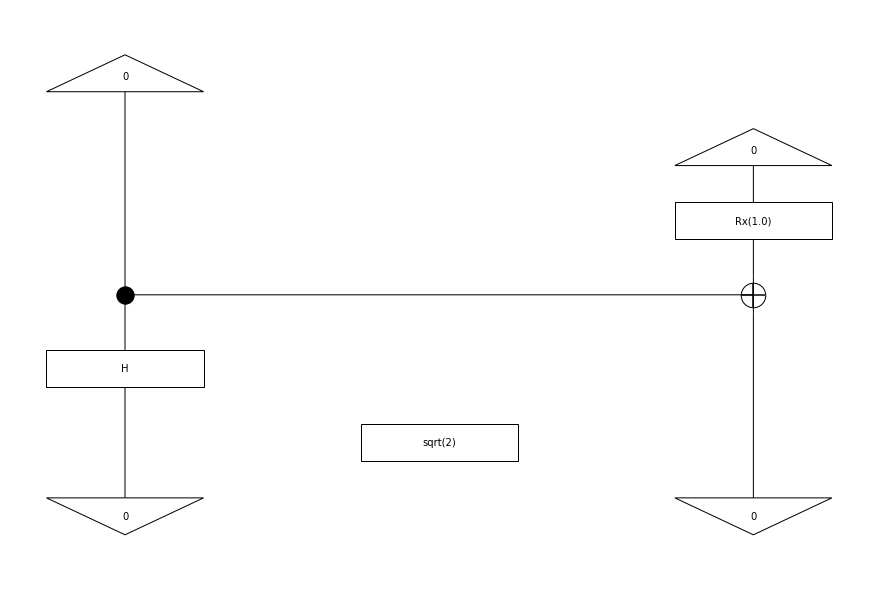


Alice is happy


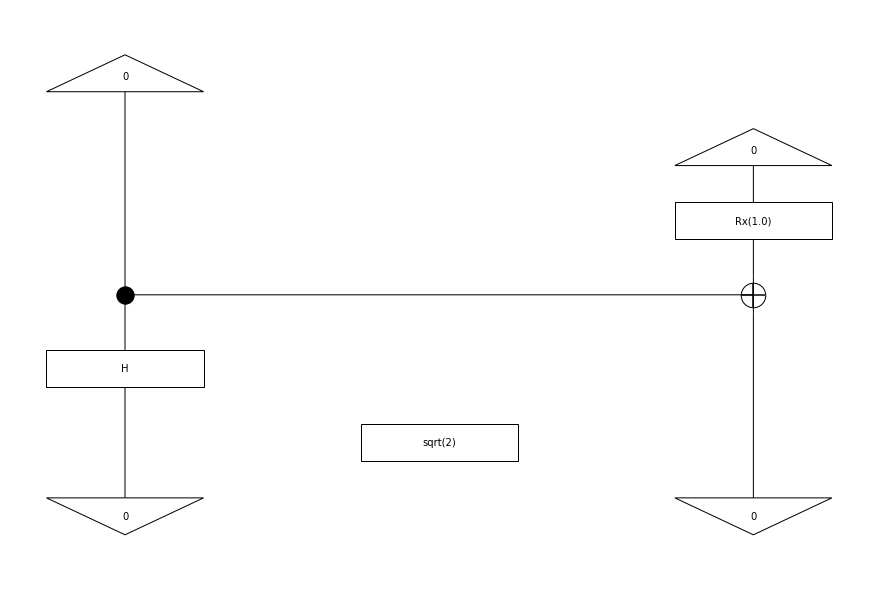


Bob is rich


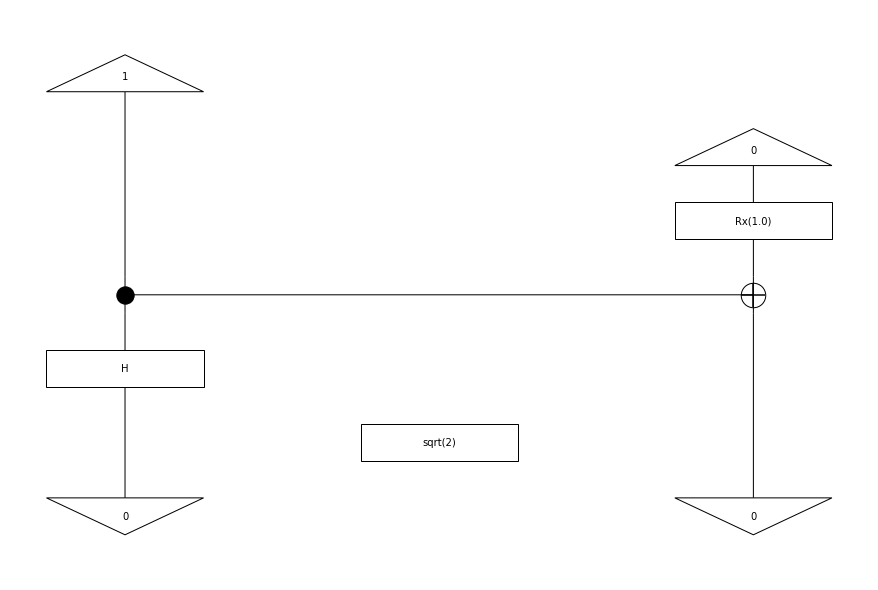


Bob is happy


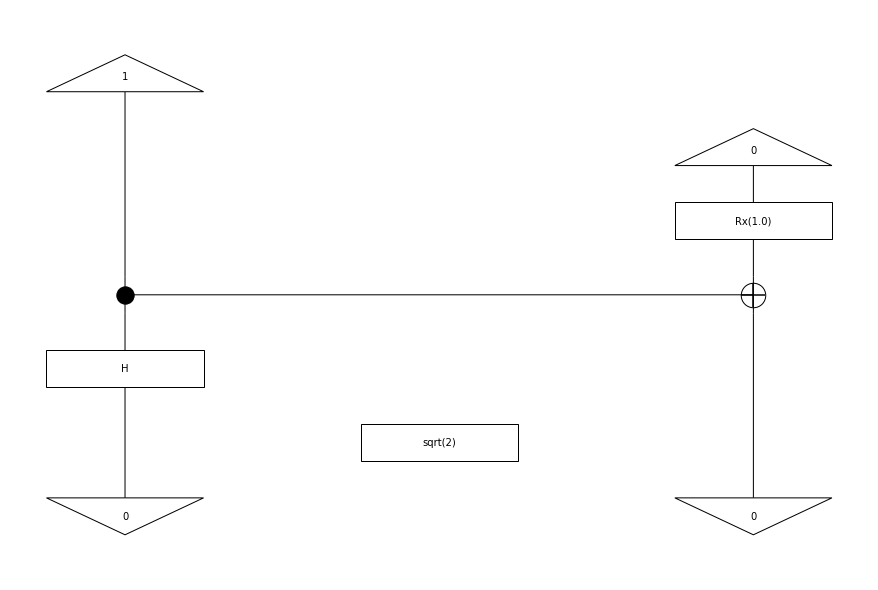


Alice loves Alice


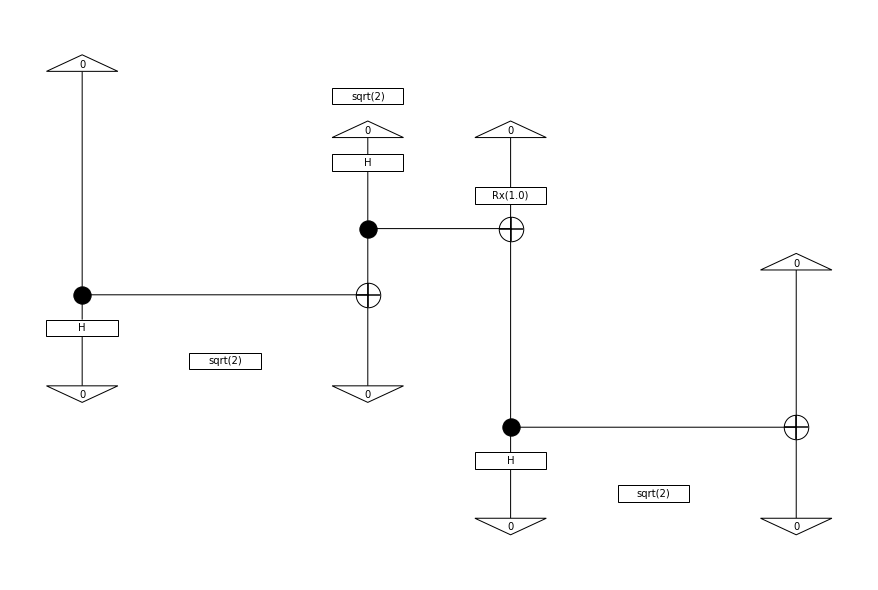


Alice loves Bob


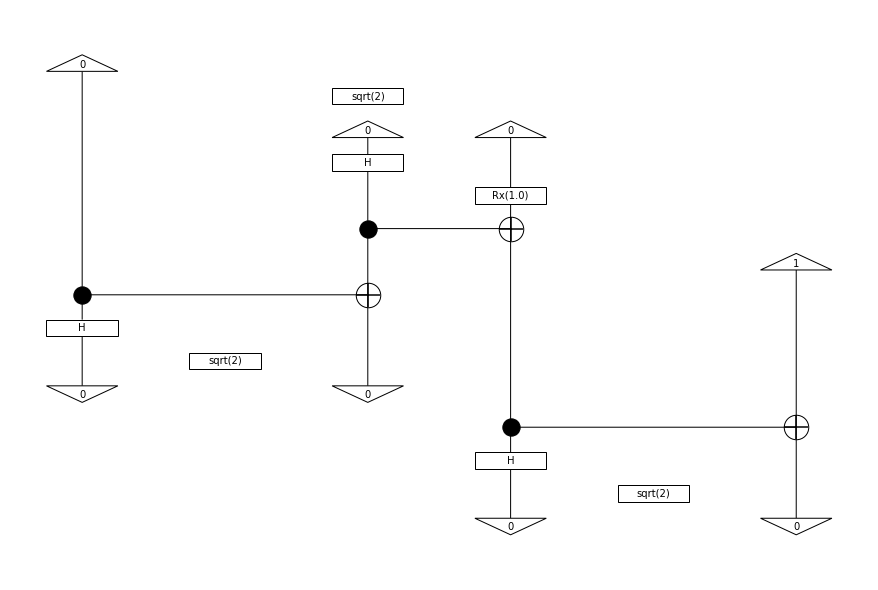


Bob loves Alice


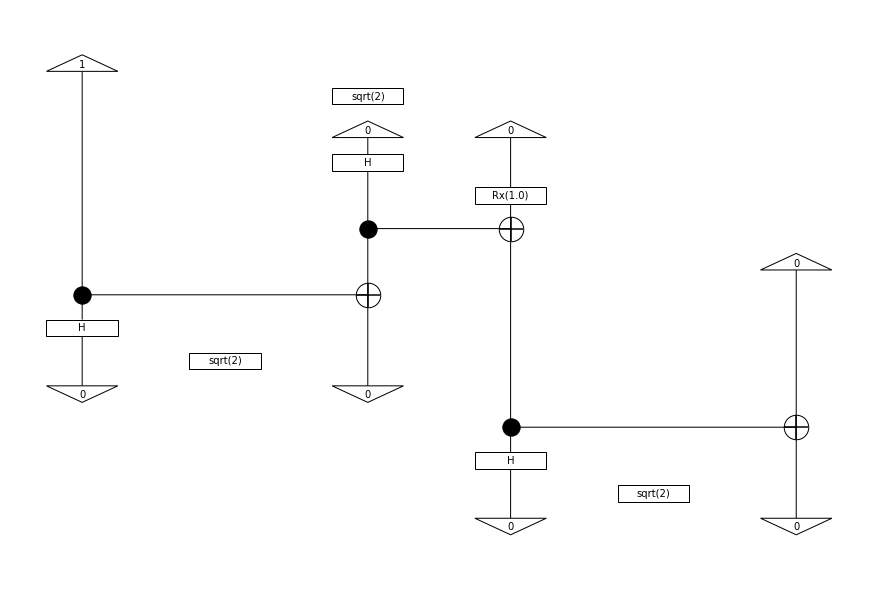


Bob loves Bob


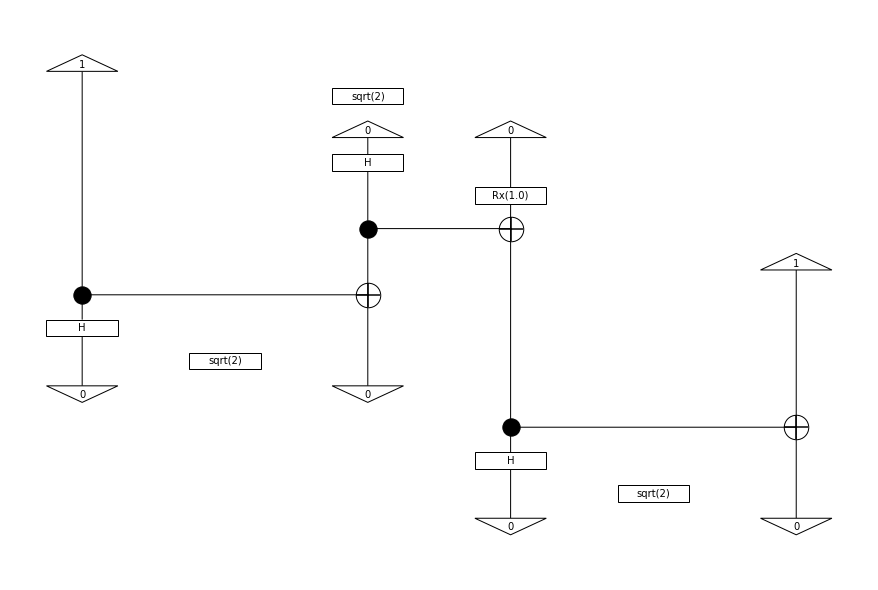


Alice who is rich is rich


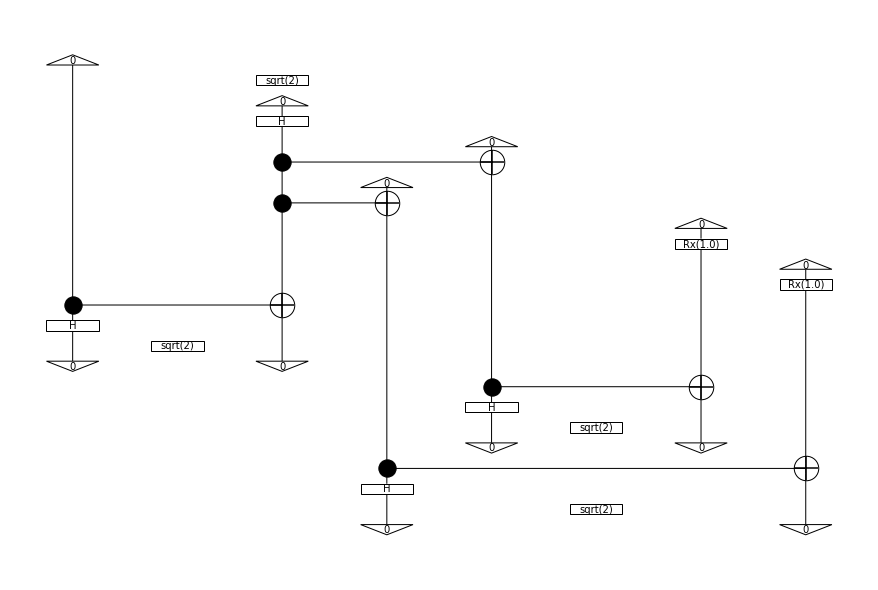


Alice who is rich is happy


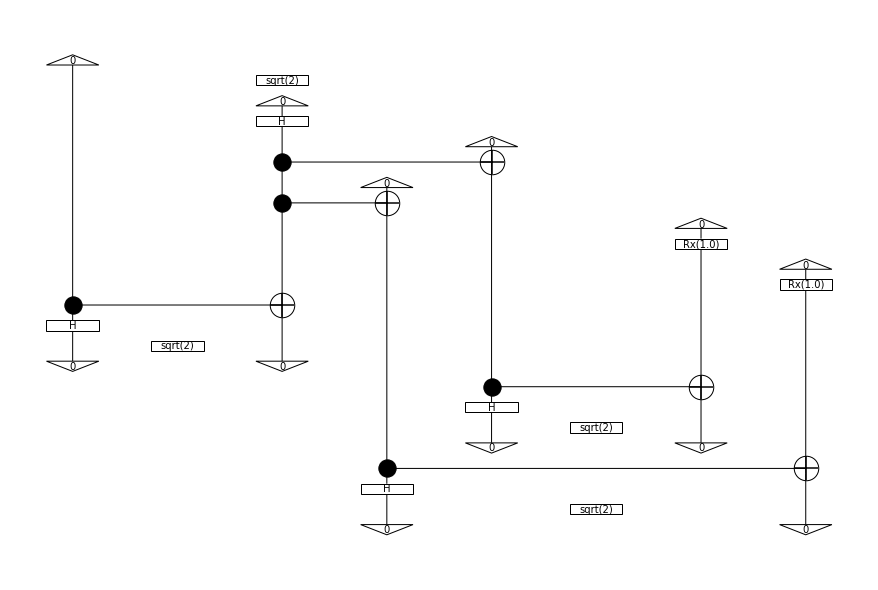


Alice who is happy is rich


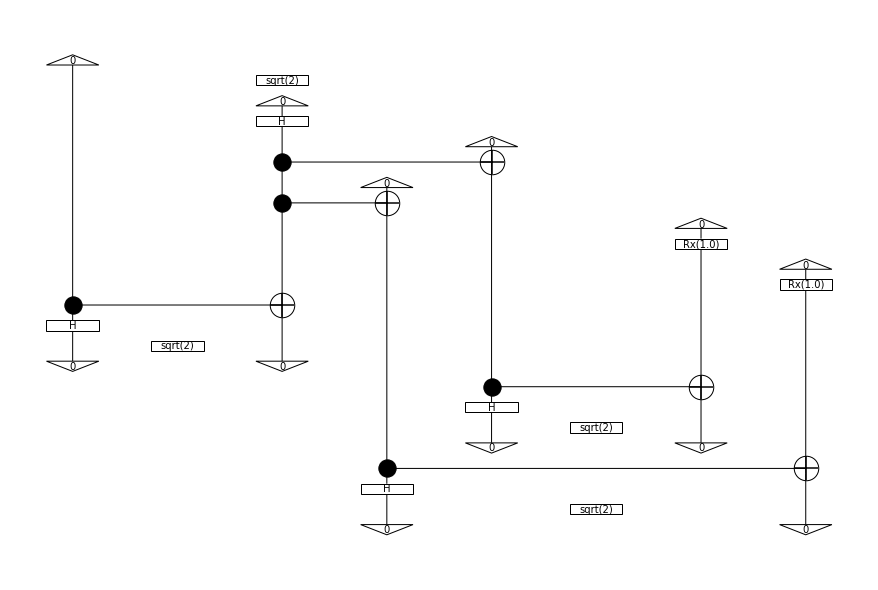


Alice who is happy is happy


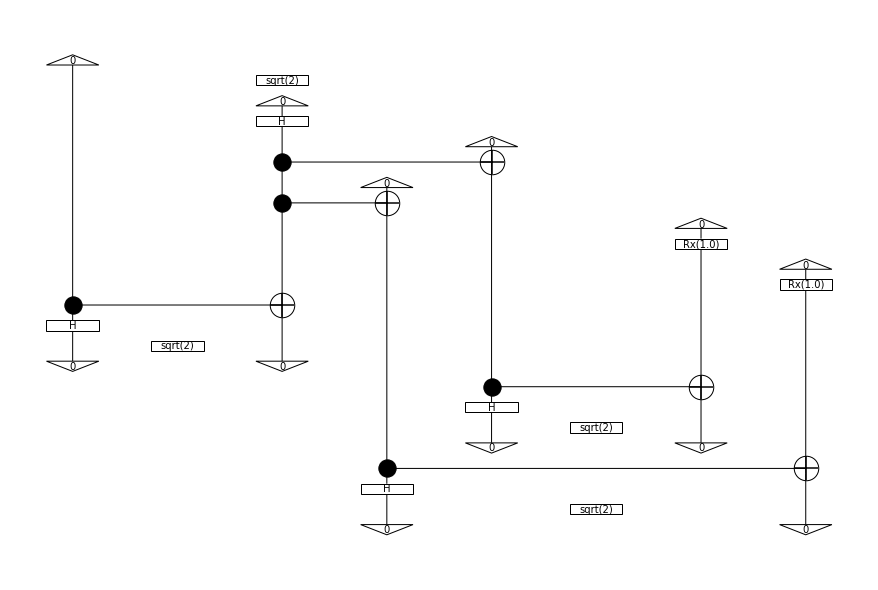


Bob who is rich is rich


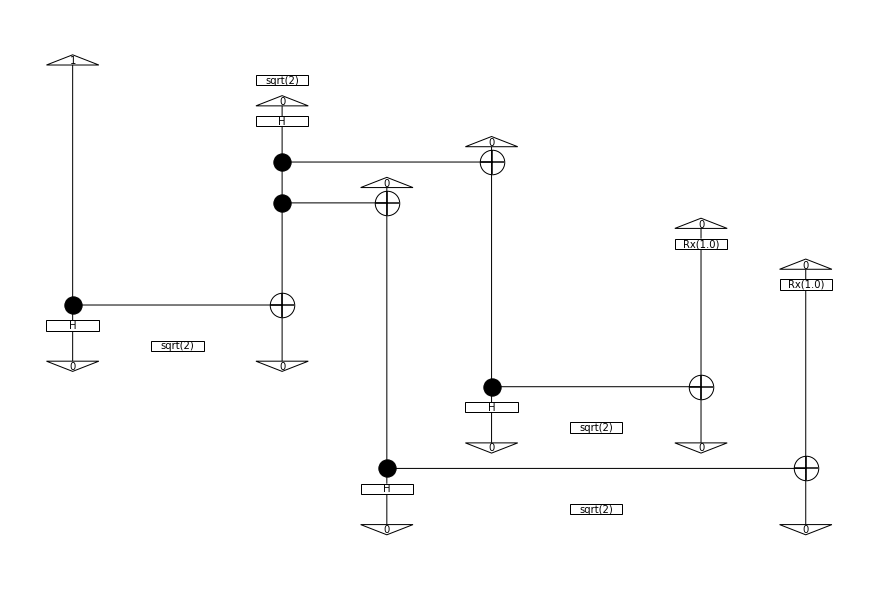


Bob who is rich is happy


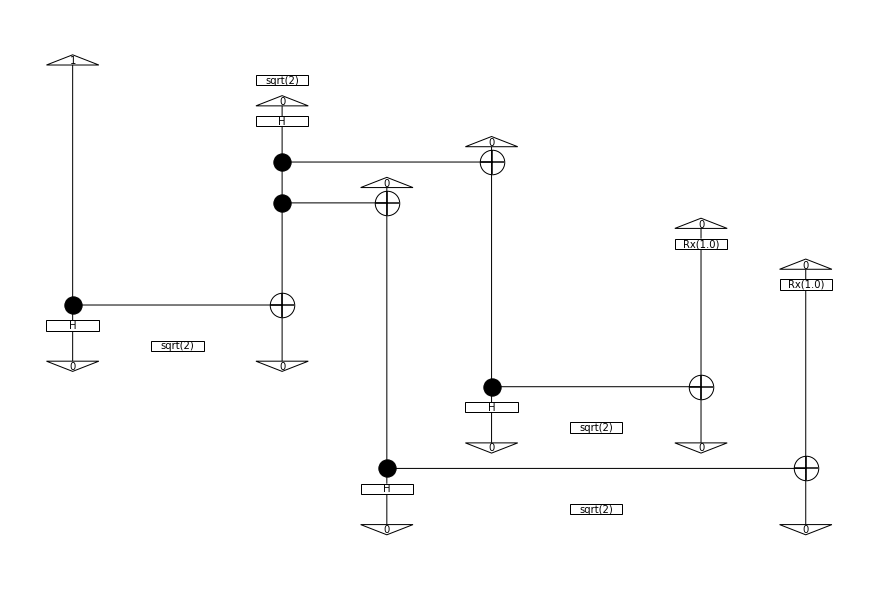


Bob who is happy is rich


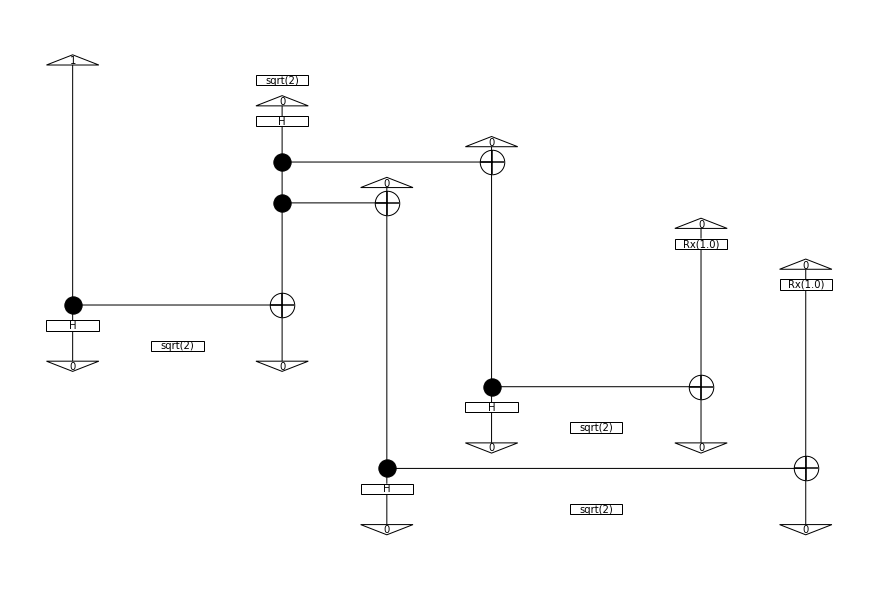


Bob who is happy is happy


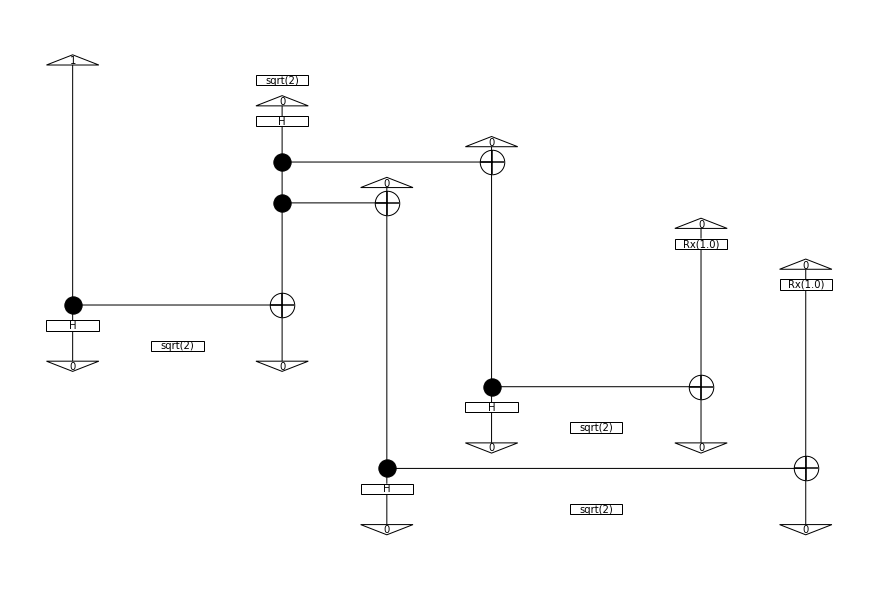


Alice who loves Alice is rich


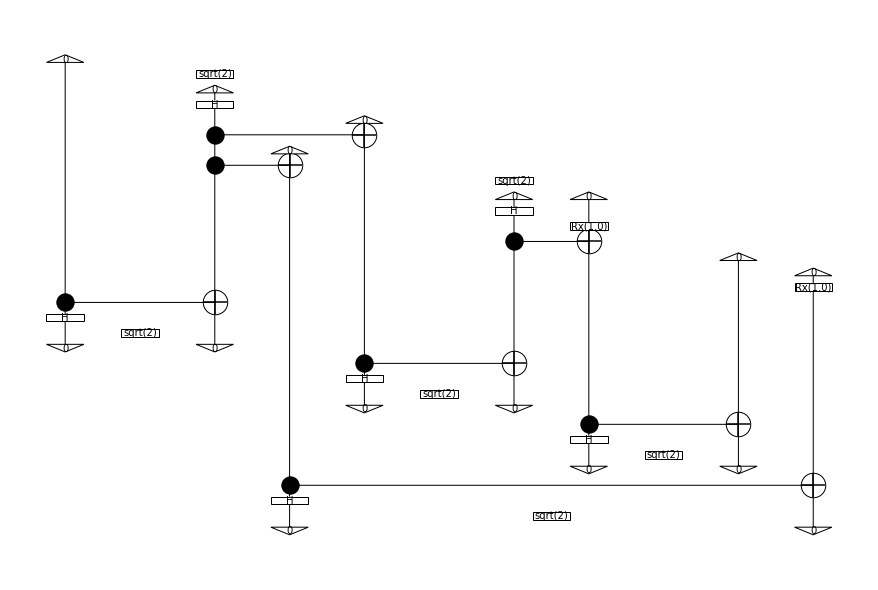


Alice who loves Alice is happy


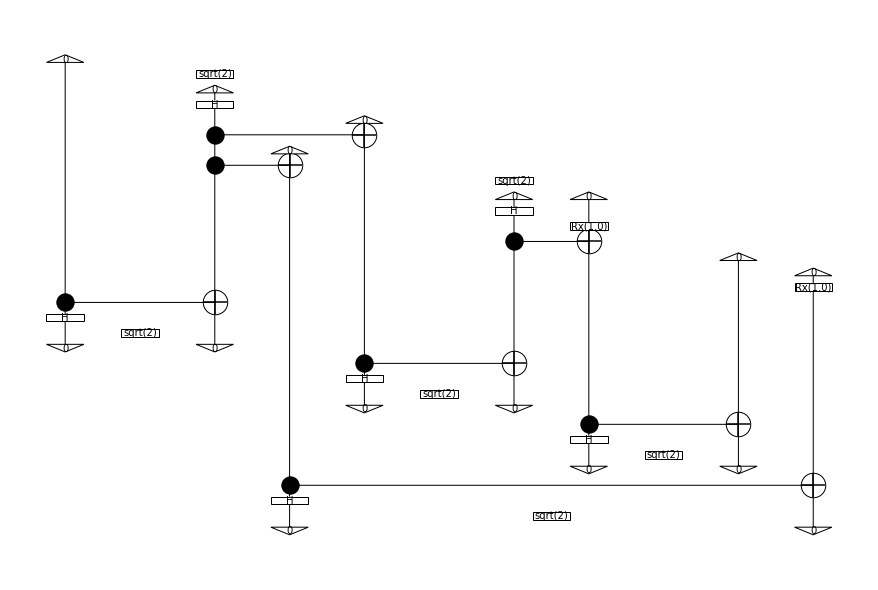


Alice who loves Bob is rich


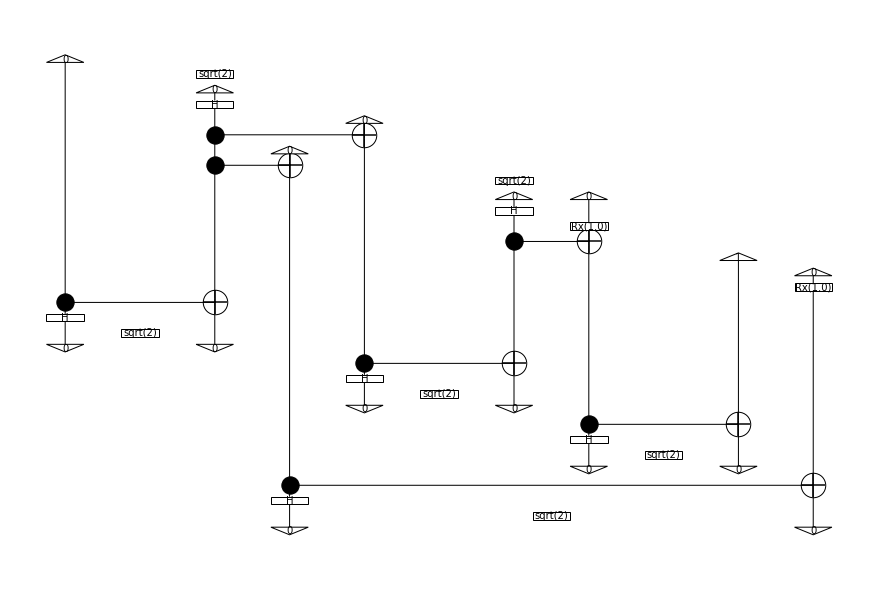


Alice who loves Bob is happy


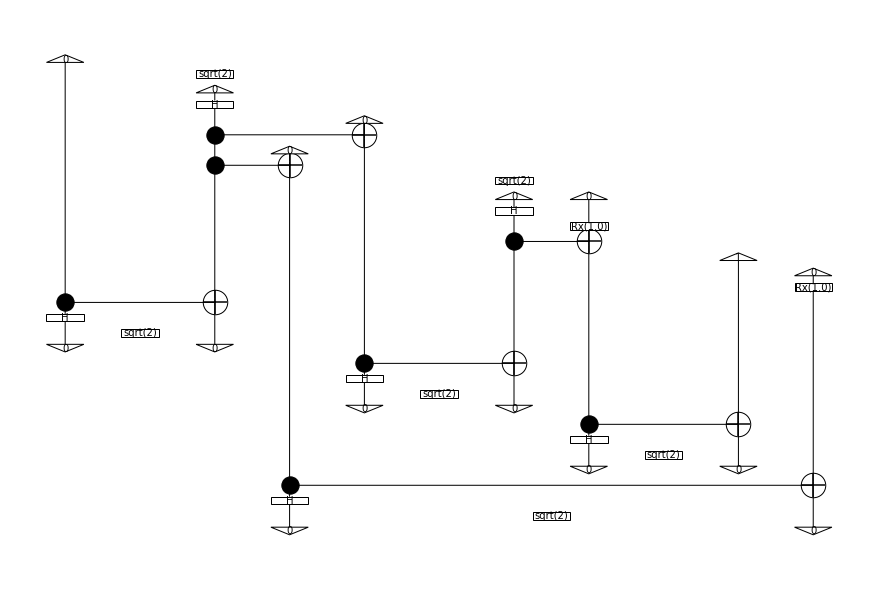

In [11]:
sentences = []
sentences2truth_values = {}
sentences2diagram = {}

csv_file = 'dataset.csv'
#csv_file = 'dataset_biaised.csv'
with open('datas/'+csv_file) as fp:
    for line in fp:
        line.strip("\n")
        sent_id, sentence, truth_value = line.split('\t')
        serialized_diagram = open('datas/serialized_sentences/'+sent_id, 'rb')
        diagram = pickle.loads(serialized_diagram.read())
        sentences.append(sentence)
        sentences2truth_values[sentence] = int(truth_value)
        sentences2diagram[sentence] = diagram
        #for visualization
        print(sentence)
        F(np.ones(N))(diagram).draw(figsize=(12, 8), aspect='auto', draw_type_labels=False, nodesize=1)
        print()

In [12]:
sentence_train, sentence_test = train_test_split(sentences, test_size=0.5, random_state=0)

In [13]:
print("True sentences:\n{}\n".format('\n'.join(sentence
    for sentence, truth_val in sentences2truth_values.items() if truth_val == 1)))
print("False sentences:\n{}".format('\n'.join(sentence
    for sentence, truth_val in sentences2truth_values.items() if truth_val == 0)))

True sentences:
Alice is rich
Alice is happy
Bob is rich
Bob is happy
Bob loves Alice
Bob loves Bob
Alice who is rich is rich
Alice who is rich is happy
Alice who is happy is rich
Alice who is happy is happy
Bob who is rich is rich
Bob who is rich is happy
Bob who is happy is rich
Bob who is happy is happy

False sentences:
Alice loves Alice
Alice loves Bob
Alice who loves Alice is rich
Alice who loves Alice is happy
Alice who loves Bob is rich
Alice who loves Bob is happy


**9) We run a classical optimization algorithm to find the parameters for which the prediction score is best on training datas**

In [14]:
def predict(params, sentence):
    epsilon = 1e-2
    return int(evaluate(F(params), sentence)[0] > 1 - epsilon)

In [15]:
#Here we see that depending on the parameter, a given diagram will evaluate to True or False
test_sentence = "Alice who loves Bob is rich"

def find_specific_prediction(test_sentence, targeted_prediction):
    prediction = None
    while not prediction == targeted_prediction:
        test_params = np.array([uniform(-1, 1) for i in range(number_parameters)])
        prediction = predict(test_params, test_sentence)
    print("Random test_params: {},\t prediction: {}".format(test_params, prediction))

find_specific_prediction(test_sentence, 0)
find_specific_prediction(test_sentence, 1)

Random test_params: [-0.7312715   0.6948675   0.52754927],	 prediction: 0
Random test_params: [-0.48986194 -0.00912983 -0.10101787],	 prediction: 1


In [16]:
Tensor.np = np  # This ensures we can differentiate Circuit.eval with respect to phases.

@jit
def training_loss(params):
    return np.mean(np.array([
        (sentences2truth_values[sentence] - evaluate(F(params), sentence)) ** 2
        for sentence in sentence_train]))

@jit
def testing_loss(params):
    return np.mean(np.array([
        (sentences2truth_values[sentence] - evaluate(F(params), sentence)) ** 2
        for sentence in sentence_test]))

step_size = 1e-2

@jit
def update(params):
    return params - step_size * grad(training_loss)(params)

In [21]:
seed(1)

#random initialisation of params
params = np.array([uniform(-1, 1) for i in range(number_parameters)])

epochs, iterations = 7, 30

for i in range(epochs):
    for j in range(iterations):
        params = update(params)

    print("Epoch {}".format(i))
    print("params['loves'] = {:.3f}".format(params[0]))
    print("params['is rich'] = {:.3f}".format(params[1]))
    print("Training score: {}%".format(int((1-training_loss(params)) * 10000) / 100))
    print("Testing score: {}%\n".format(int((1-testing_loss(params)) * 10000) / 100))

Epoch 0
params['loves'] = -0.848
params['is rich'] = 0.650
Training score: 70.76%
Testing score: 57.65%

Epoch 1
params['loves'] = -0.888
params['is rich'] = 0.640
Training score: 71.34%
Testing score: 54.62%

Epoch 2
params['loves'] = -0.907
params['is rich'] = 0.637
Training score: 71.47%
Testing score: 53.32%

Epoch 3
params['loves'] = -0.919
params['is rich'] = 0.635
Training score: 71.52%
Testing score: 52.62%

Epoch 4
params['loves'] = -0.927
params['is rich'] = 0.635
Training score: 71.54%
Testing score: 52.19%

Epoch 5
params['loves'] = -0.932
params['is rich'] = 0.635
Training score: 71.55%
Testing score: 51.9%

Epoch 6
params['loves'] = -0.936
params['is rich'] = 0.634
Training score: 71.55%
Testing score: 51.69%



**Training and test set are split (50% - 50%), so we see the overall best fitting score is 62.1%**